# Drug Consumption

In [1]:
#%matplotlib widget
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sklearn.datasets as datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer

from mpl_toolkits.mplot3d import Axes3D

from itertools import combinations

from IPython.display import display

import seaborn as sns

import datetime as dt

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

## Importazione del dataset

Il dataset è stato ottenuto da un survey effettuato online in forma anonima. 
Sono 12 gli attributi conosciuti per ogni partecipante:
- età;
- sesso; 
- livello di educazione; 
- nazione di residenza; 
- etnicità;
- 5 score relativi ai tratti della personalità dei Five Factor Model:
  * Neuroticism (Nscore);
  * Extraversion (Escore);
  * Openness to Experience (Oscore);
  * Agreeableness (Ascore);
  * Conscientiousness (Cscore).
- Barratt Impulsiveness Scale version 11 (BIS-11);
- Impulsivity Sensation-Seeking scale (ImpSS).

Inoltre ai partecipanti è stato chiesto se avessero mai usato o con quale frequenza, 18 sostanze psicoattive del sistema centrale nervoso.

In [2]:
drugs = pd.read_csv('Dataset/drug_consumption.data',header=None,index_col=0)

colonne = {1:'Age', 2:'Gender', 3:'Education', 4:'Country', 5:'Ethnicity', 
           6:'Nscore', 7:'Escore', 8:'Oscore', 9:'Ascore',  10:'Cscore', 
           11:'Impulsive BIS-11', 12:'SS ImpSS', 13:'Alcohol',14:'Amphet',
           15:'Amyl', 16:'Benzos', 17:'Caff', 18:'Cannabis', 19:'Chocolate',
           20:'Cocaine', 21:'Crack', 22:'Ecstasy', 23:'Heroin', 24:'Ketamine',
           25:'Legalh', 26:'LSD', 27:'Meth', 28:'Mushrooms', 29:'Nicotine', 
           30:'Semer', 31:'VSA'}

drugs = drugs.rename(columns=colonne)

Le righe corrispondenti alle persone che hanno usato Semer sono state eliminate, poichè è una droga fittizia (Semeron) usata per identificare le persone che non rispondevano seriamente al survey. Dopodichè viene anche cancellata la relativa colonna.

In [3]:
indici=drugs.loc[drugs['Semer']!='CL0'].index

In [4]:
drugs=drugs.drop(index=indici)
drugs=drugs.drop(columns='Semer')

Per analizzare il dataset ho deciso ci concentrami su un problema di tipo binario. Ho così creato due classi 'User' = 1 e 'Non User' = 0 accorpando le classi precedenti:
- CL0: Never Used --> 0  
- CL1: Used over a Decade Ago --> 0  
- CL2: Used in Last Decade --> 1  
- CL3: Used in Last Year --> 1  
- CL4: Used in Last Month --> 1  
- CL5: Used in Last Week --> 1  
- CL6: Used in Last Day --> 1

In [5]:
tipi_droghe = list(drugs.columns[12:30].values)
#categoria user 1, non-user 0
for drug in tipi_droghe:
    drugs[drug]=drugs[drug].replace(['CL0','CL1','CL2','CL3','CL4','CL5','CL6'],value=[0,0,1,1,1,1,1])
display(drugs)

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,VSA
0,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,0,0,0,0,0,1,0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,0,1,0,1,0,1,1,0,1,0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,0,0,0,0,0,0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,0,1,0,0,0,0,1,0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1884,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,-1.13788,...,0,0,0,0,1,1,0,0,0,1
1885,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,-1.51840,...,0,1,0,0,1,1,1,1,1,0
1886,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,...,0,1,0,1,0,1,0,1,1,0


## Parte di analisi iniziale del dataset

Inizio l'analisi stampando le matrici di correlazione tra targets e features, tra features e features e tra target e target.

In [6]:
#Matrici di correlazione
corr_tf = drugs.corr().iloc[range(12,30),range(0,12)]  #target e feature
corr_ff = drugs.corr().iloc[range(0,12),range(0,12)]   #feature e feature
corr_tt = drugs.corr().iloc[range(12,30),range(12,30)] #target e target

print('Matrice correlazione tra targets e features')
display(corr_tf.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1))
print('Matrice correlazione tra features')
display(corr_ff.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1))
print('Matrice correlazione tra targets')
display(corr_tt.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1))

Matrice correlazione tra targets e features


,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive BIS-11,SS ImpSS
Alcohol,-0.102995,0.008307,0.009410,-0.043823,0.108534,0.036648,-0.002143,0.015979,-0.052376,-0.071072,0.066268,0.095408
Amphet,-0.309972,-0.234240,-0.175906,-0.360674,0.071231,0.121263,-0.022160,0.232068,-0.117507,-0.222708,0.267283,0.354206
Amyl,-0.162739,-0.136088,0.001888,0.076304,0.025146,0.036470,0.046695,0.072364,-0.062966,-0.099407,0.115029,0.187583
Benzos,-0.142166,-0.135375,-0.123458,-0.381896,0.100331,0.225929,-0.076616,0.218954,-0.140787,-0.197527,0.207404,0.245140
Caff,-0.088573,-0.027055,0.003170,-0.074265,0.108348,-0.001901,0.047679,0.075178,-0.014413,-0.049993,0.051516,0.081073
Cannabis,-0.435386,-0.239002,-0.188571,-0.457074,0.123796,0.139626,-0.040188,0.349622,-0.168638,-0.272776,0.294855,0.408797
Chocolate,-0.038137,-0.000217,-0.036883,0.041718,0.035602,-0.003503,-0.013284,0.033186,0.012281,-0.032552,-0.018161,0.000748
Cocaine,-0.231425,-0.166110,-0.114363,-0.266740,0.080266,0.130427,0.025125,0.195832,-0.173857,-0.196594,0.252042,0.331658
Crack,-0.073810,-0.141437,-0.154403,-0.217020,0.050013,0.096502,-0.043602,0.098039,-0.091008,-0.124302,0.180706,0.178580
Ecstasy,-0.383453,-0.235001,-0.178243,-0.334555,0.065091,0.097555,0.041514,0.290950,-0.123841,-0.226286,0.250385,0.396804


Matrice correlazione tra features


,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive BIS-11,SS ImpSS
Age,1.000000,0.110546,0.156719,0.352023,-0.068967,-0.137952,-0.031433,-0.226795,0.063937,0.184265,-0.191432,-0.331521
Gender,0.110546,1.000000,0.197904,0.218806,-0.002845,0.072980,0.058690,-0.133809,0.219119,0.182411,-0.169518,-0.246434
Education,0.156719,0.197904,1.000000,0.223474,-0.035493,-0.102268,0.119156,0.059153,0.089528,0.241438,-0.131714,-0.128587
Country,0.352023,0.218806,0.223474,1.000000,-0.126974,-0.135600,0.111731,-0.340646,0.152536,0.214892,-0.230975,-0.343111
Ethnicity,-0.068967,-0.002845,-0.035493,-0.126974,1.000000,0.048206,0.018086,0.085041,-0.041652,-0.032151,0.085264,0.102193
Nscore,-0.137952,0.072980,-0.102268,-0.135600,0.048206,1.000000,-0.431535,0.007530,-0.217776,-0.392354,0.173384,0.078152
Escore,-0.031433,0.058690,0.119156,0.111731,0.018086,-0.431535,1.000000,0.244784,0.158082,0.307570,0.113695,0.208322
Oscore,-0.226795,-0.133809,0.059153,-0.340646,0.085041,0.007530,0.244784,1.000000,0.036846,-0.058607,0.275363,0.419486
Ascore,0.063937,0.219119,0.089528,0.152536,-0.041652,-0.217776,0.158082,0.036846,1.000000,0.245438,-0.229945,-0.208319
Cscore,0.184265,0.182411,0.241438,0.214892,-0.032151,-0.392354,0.307570,-0.058607,0.245438,1.000000,-0.336175,-0.230334


Matrice correlazione tra targets


,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Chocolate,Cocaine,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,VSA
Alcohol,1.000000,0.078167,0.080546,0.053796,0.158635,0.121311,0.081528,0.115318,0.035494,0.103258,0.040718,0.076652,0.064320,0.067271,-0.001539,0.074650,0.114940,0.044712
Amphet,0.078167,1.000000,0.371636,0.462191,0.106142,0.469015,0.018394,0.580816,0.319952,0.598070,0.356405,0.411723,0.481242,0.492966,0.413386,0.482546,0.342217,0.299779
Amyl,0.080546,0.371636,1.000000,0.225727,0.060374,0.292612,0.036888,0.380926,0.139199,0.394791,0.132349,0.346643,0.270273,0.215034,0.080369,0.271078,0.196082,0.130678
Benzos,0.053796,0.462191,0.225727,1.000000,0.054793,0.352228,-0.001604,0.425408,0.324073,0.382626,0.393700,0.300868,0.345269,0.350946,0.468176,0.365075,0.258485,0.290867
Caff,0.158635,0.106142,0.060374,0.054793,1.000000,0.112276,0.124428,0.099033,0.034544,0.107206,0.025828,0.057529,0.085196,0.074578,0.038461,0.099789,0.144652,0.052465
Cannabis,0.121311,0.469015,0.292612,0.352228,0.112276,1.000000,0.049003,0.452206,0.215445,0.521128,0.216192,0.301737,0.525937,0.420386,0.299836,0.495997,0.531749,0.235476
Chocolate,0.081528,0.018394,0.036888,-0.001604,0.124428,0.049003,1.000000,0.011097,-0.021218,0.036702,-0.015420,0.033662,0.021945,0.026149,0.014444,0.028564,0.040339,-0.023400
Cocaine,0.115318,0.580816,0.380926,0.425408,0.099033,0.452206,0.011097,1.000000,0.394155,0.635730,0.412741,0.449975,0.444422,0.443061,0.352211,0.480169,0.358677,0.275807
Crack,0.035494,0.319952,0.139199,0.324073,0.034544,0.215445,-0.021218,0.394155,1.000000,0.280675,0.502475,0.257868,0.203636,0.272052,0.366089,0.277000,0.189333,0.274639
Ecstasy,0.103258,0.598070,0.394791,0.382626,0.107206,0.521128,0.036702,0.635730,0.280675,1.000000,0.301328,0.510174,0.588221,0.598523,0.316937,0.599771,0.369089,0.285414


Dalle matrici non si nota mai una forte correlazione. Di particolare si può osservare che la corellazione tra i targets è sempre positiva, se pur debolmente anche nella maggior parte dei casi. 

In [8]:
#y dizionario con chiave droga e valore target
y={}
for drug in tipi_droghe:
    y[drug] = list(drugs[drug])

Successivamente stampo dei grafici a barre per vedere come sono distribuiti gli User e Non User per ogni droga.

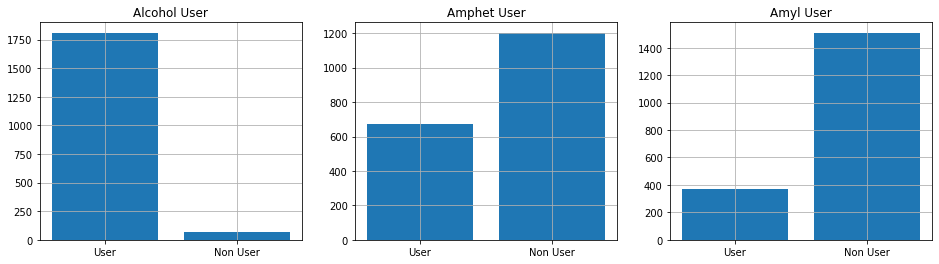

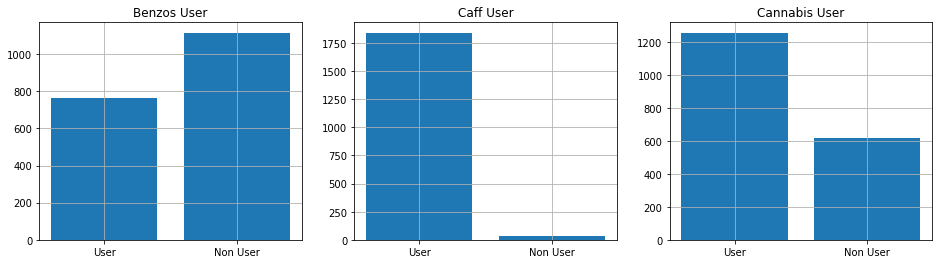

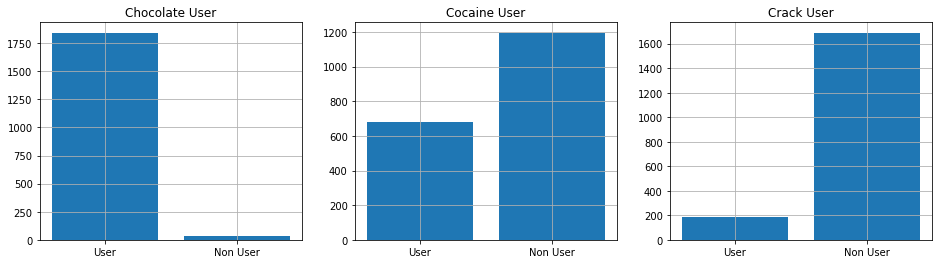

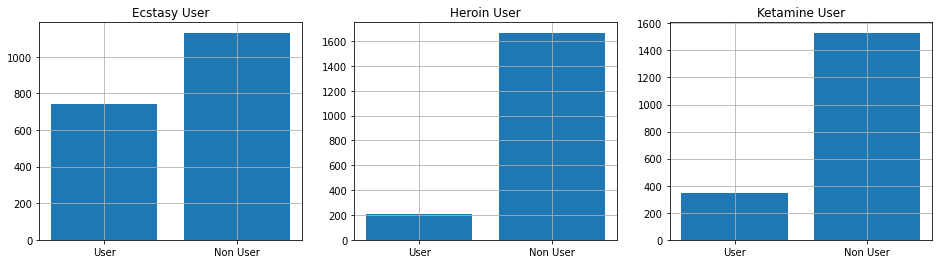

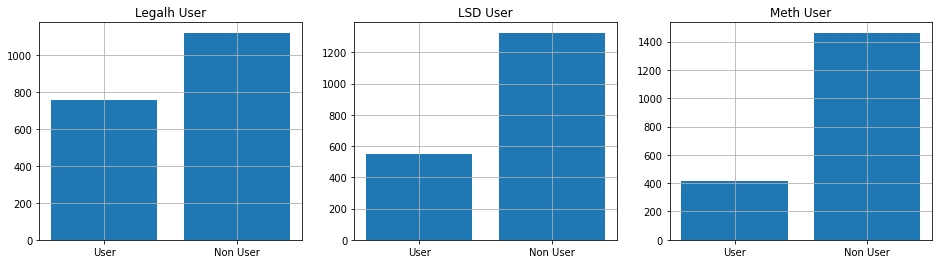

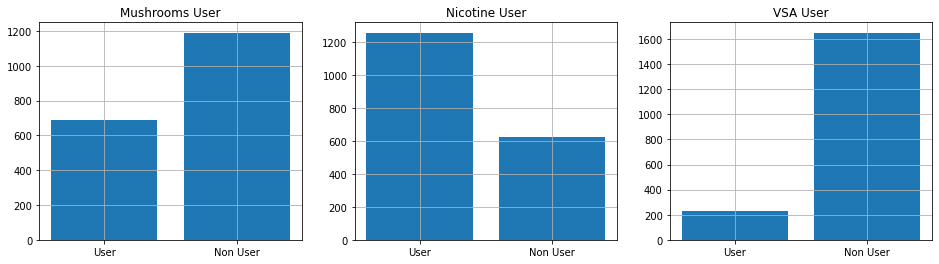

In [9]:
for i in range(0,len(tipi_droghe),3):
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    axs[0].bar([0,1], [y[tipi_droghe[i]].count(1),y[tipi_droghe[i]].count(0)])
    axs[0].set_xticks([0,1])
    axs[0].set_xticklabels(['User', 'Non User'])
    axs[0].set_title(f'{tipi_droghe[i]} User')
    axs[0].grid()
    if i+1<len(tipi_droghe):
        axs[1].bar([0,1], [y[tipi_droghe[i+1]].count(1),y[tipi_droghe[i+1]].count(0)])
        axs[1].set_xticks([0,1])
        axs[1].set_xticklabels(['User', 'Non User'],)
        axs[1].set_title(f'{tipi_droghe[i+1]} User')
        axs[1].grid()
    if i+2<len(tipi_droghe):   
        axs[2].bar([0,1], [y[tipi_droghe[i+2]].count(1),y[tipi_droghe[i+2]].count(0)])
        axs[2].set_xticks([0,1])
        axs[2].set_xticklabels(['User', 'Non User'],)
        axs[2].set_title(f'{tipi_droghe[i+2]} User')
        axs[2].grid()
    plt.show()

Si nota che il dataset è sempre sbilanciato. Per l'alcool, la caffeina e il cioccolato è fortemente sbilanciato. Per lo studio successivo con i metodi di machine learning applicherò sia l'oversampling che l'undersampling.

## Principle Component Analysis

La Principle Component Analysis (PCA) ha come idea principale quella di cercare la più accurata rappresentazione dei dati in uno spazio di dimensione inferiore. I dati devono essere quindi proiettati lungo l'asse che massimizza la varianza. Una prima analisi sulla distribuzione normale multivariata ci consiglia di guardare alla matrice di covarianza dei dati.   

Sia **V** uno spazio lineare **d**-dimensionale e **W** un suo sottospazio **k**-dimensionale. Si può sempre trovare un insieme di vettori **d**-dimensionali {$e_1, e_2, ..., e_k$} che formano una base ortonormale per **W**.   

Per trovare la più accurata rappresentazione dei dati $D=${$x_1,x_2,...,x_n$} nel sottospazio **W**, che ha dimensione $k<d$. Sia {$e_1, e_2, ..., e_k$} base ortonormale per **W**. Ogni vettore di **W** può essere scritto come $\sum_{i=1}^{k} \alpha_{i}e_i$, con $\alpha_1,...,\alpha_k$ scalari. Quindi $x_1$ può essere rappresentato da un certo vettore di W come $\sum_{i=1}^{k} \alpha_{1i}e_i$, con un $$errore = \Vert x_1-\sum_{i=1}^{k} \alpha_{1i}e_i \Vert^2$$  
Per trovare l'errore totale bisogna fare la sommatoria su tutti i dati $x_j$ e ottenere $$J(e_1,...,e_k,\alpha_{11},...,\alpha{nk})= \sum_{j=1}^{n}\Vert x_j-\sum_{i=1}^{k} \alpha_{ji}e_i \Vert^2$$
Per minimizzare **J**, bisogna fare le derivate parziali sugli $\alpha_{ml}$. Si ottiene il valore ottimale di $\alpha_{ml}=x_m^{t}e_l$. Svolgendo i conti si trova che minimizzare **J** è equivalente a massimizzare $$\sum_{i=1}^{k}e_i^{t}Se_i$$ con $S=\sum_{j=1}^{n}x_jx_j^{t}$, detta scatter matrix.

Imponendo le condizioni di ortonormalità dei {$e_1, e_2, ..., e_k$} e svolgendo poi le derivate parziali sui vettori {$e_1, e_2, ..., e_k$} si arriva a definire $$J(e_1,...,e_k)= \sum_{j=1}^{n}\Vert x_j\Vert^2-\sum_{i=1}^{k} \lambda_{i} $$ con $\lambda_i$ autovalori di **S**. Maggiore è l'autovalore di **S**, maggiore è la varianza nella derizione corrispondete all'autovettore. Così la PCA può essere pensata come trovare una nuova base ortogonale ruotando i vecchi assi fino alla direzione di massima varianza trovata.  
Siano {$e_1,...,e_d$} i **d** autovettori della matrice S, ordinati in modo decrescente di autovalori. Senza nessuna approssimazione possiamo scrivere ogni dato $x_i$ come: $$x_i=\sum_{j=1}^d \alpha_j e_j$$ Le prime **k** componenti, scelte dalla PCA come le più importanti, sono l'approssimazione di $x_i$. Esse sono in ordine di importanza. Le successive, da **k+1** a **d**, sono l'errore di approssimazione. I coefficienti $\alpha_m=x_i^t e_m$ sono dette componenti principali.  
Ora l'ultimo passo è quelo di cambiare le coordinate per ottenere il vettore **y** **k**-dimensionale. Sia la matrice $E=[e_1 ... e_k]$. Allora la trasformazione è $y=E^tx$.  

In pochi passaggi si può riassumere la riduzione di dimensionalità con la PCA.  
Siano i dati $D=\{x_1,...,x_n\}$. Ogni $x_i$ è un vettore **d**-dimensionale. Con la PCA vogliamo ridurre la sua dimensione a **k**.  
1. Trovo la media campionaria: $\mu=\frac{1}{n}\sum_{i=1}^n x_i$
2. Sottraggo la media dai dati: $z_i=x_i-\mu$
3. Calcolo la scatter matrix: $S=\sum_{i=1}^n z_i z_i^t$
4. Calcolo gli autovettori $e_1, e_2, ..., e_k$ corrispondenti ai **k** autovalori più grandi di **S**
5. Siano $e_1, e_2, ..., e_k$ le colonne della matrice $E=[e_1 ... e_k]$
6. Il vettore $y=E^t z$ così ottenuto è la più vicina approssimazione a **x**.

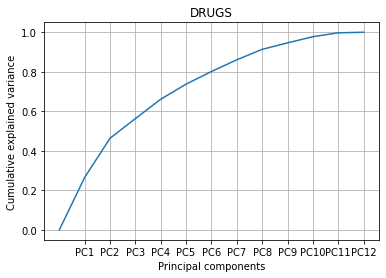

In [9]:
X_drugs = drugs.iloc[:,range(0,12)].values
X_drugs_work = drugs.iloc[:,range(0,12)]
pca_drugs = PCA()
pca_drugs.fit(X_drugs)

plt.figure()
plt.plot(np.insert(np.cumsum(pca_drugs.explained_variance_ratio_), 0, 0))#somma cumulativa delle varianze
#con insert parto da zero e non dal primo valore di PC1
plt.title('DRUGS')
plt.xticks(ticks=np.arange(1, pca_drugs.n_features_ + 1), 
           labels=[f'PC{i}' for i in range(1, pca_drugs.n_features_ + 1)])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()


In [10]:
pca = PCA(0.90)

pca.fit(X_drugs)

Y_drugs_m = pca.transform(X_drugs)

df_pca = pd.DataFrame({'val':pca.n_components_,'varianza':pca.explained_variance_ratio_.sum()}, index =['n.PC'])
df_pca

,val,varianza
n.PC,8,0.913476


Poichè per avere più di un 90% di varianza spiegata servono quasi la totalità delle PC e dato comunque il basso numero di features, ho preferito usare tutte quante le  colonne per l'analisi dei dati, poichè non avrei avuto un notevole risparmio computazionale.

# Linear Discriminant Analysis

La Linear Discriminant Analysis (LDA) è una generalizzazioe della Fisher Linear Discriminant e serve per risolvere problemi di data classification. L'idea principiale è quella di trovare una proiezione dei dati tale per cui le classi vengono ben separate.  
Suppongo di avere due classi e dei dati **d**-dimensionali. I dati della prima classe sono $n_1$ e i restanti $n_2$ sono della seconda classe. Considero la retta data dal vettore unitario $v$. Lo scalare $v^t x_i$ è la distanza della proiezione, in una dimensione, dall'origine.  
Per misurare la separazione delle classi considero in primis la differenza tra le medie delle proiezioni dei dati delle classi 1 e 2. $$\vert \hat{\mu_1}-\hat{\mu_2} \vert = \vert v^t\mu_1-v^t\mu_2 \vert $$ con $\mu_1, \mu_2$ media dei dati delle classi.  
Il problema è che non considerando la varianza, una grande differenza tra le medie delle proiezioni non significa una buona separazione tra le classi. Bisogna quindi normalizzare questa differenza per un fattore proporzionale alla varianza. Siano $y_i=v^t x_i$ le proiezioni dei campioni. Lo *scatter* per i campioni proiettati della classe 1 è $$s_1^2=\sum_{y_i\in Classe 1} (y_i-\hat{\mu_1})^2$$ e lo scatter per la classe 2 $$s_2^2=\sum_{y_i\in Classe 2} (y_i-\hat{\mu_2})^2$$
L'obbiettivo ora è quello di trovare la direzione $v$ che massimizza $$J(v)=\frac{(\hat{\mu_1}-\hat{\mu_2})^2}{s_1^2+s_2^2}$$
Riscrivendo $J(v)$ in funzione di $v$, facendo poi la derivata su $v$ e imponendola uguale a zero, si ottiene che la direzione è 
$$v=S_w^{-1}(\mu_1-\mu_2)$$ con $S_w=S_1+S_2$ e $$S_1=\sum_{x_i\in Classe 1} (x_i-\mu_1)(x_i-\mu_1)^t   
S_2=\sum_{x_i\in Classe 2} (x_i-\mu_2)(x_i-\mu_2)^t$$

Per capire quale features fossero le più significative per l'analisi dell'utilizzo di ciascuna sostanza, ho creato tutte le loro possibili combinazioni da utilizzare per la LDA. Successivamente verrà eseguita una LDA per ogni combinazione e seleziono il set di features che porta ad avere il valore più alto di F1-score.

In [11]:
X_drugs_comb={}
combinazioni={}

for i in range (3,13):
    combinazioni[i]=list(combinations(range(0,12), i))
for i in range(3,12):
    for j in range (0,len(combinazioni[i])):
        X_drugs_comb[f'{(combinazioni[i][j])}']=drugs.iloc[:,list(combinazioni[i][j])].values

In [12]:
# Inizializzazione degli oggetti per oversampling e undersampling
ros = RandomOverSampler(random_state=0)
rus = RandomUnderSampler(random_state=0)

#### Over Sampling

La LDA viene addestrata sui dati bilanciati dell'oversampling e successivamente testata sui dati tenuti come porzione di testing.

In [48]:
lda_over={}
prectop_over={} #dizionario con chiave droga e valore massimo di f1_score
keytop_over={}  #chiave droga e valore lista di feature che dà il migliore f1_score

for drug in tipi_droghe:   
    prectop_over[drug]=0
    keytop_over[drug]=[]
    lda_over[drug]=LDA()
    for keys in X_drugs_comb.keys():
        X_train, X_test, y_train, y_test = train_test_split(X_drugs_comb[keys], y[drug], train_size = 0.5,
                                                            random_state=1, shuffle=True, stratify=y[drug])
        X_over_train, y_over_train = ros.fit_resample(X_train, y_train)
        lda_over[drug].fit(X_over_train,y_over_train)
        y_pred=lda_over[drug].predict(X_test)
        prec = f1_score(y_test, y_pred, average='weighted',zero_division=1)
        
        if prectop_over[drug]<prec:
            prectop_over[drug]=prec #trovo la massima precisione per ogni droga
            keytop_over[drug]=keys  #trovo il miglior set di feature per ogni droga

#### Under Sampling

La LDA viene addestrata sui dati bilanciati dell'undersampling e successivamente testata sui dati tenuti come porzione di testing.

In [49]:
lda_under={}
prectop_under={} #dizionario con chiave droga e valore massimo di f1_score
keytop_under={}  #chiave droga e valore lista di feature che dà il migliore f1_score

for drug in tipi_droghe:   
    prectop_under[drug]=0
    keytop_under[drug]=[]
    lda_under[drug]=LDA()
    for keys in X_drugs_comb.keys():
        X_train, X_test, y_train, y_test = train_test_split(X_drugs_comb[keys], y[drug], train_size = 0.5,
                                                            random_state=1, shuffle=True, stratify=y[drug])
        X_under_train, y_under_train = rus.fit_resample(X_train, y_train)
        lda_under[drug].fit(X_under_train,y_under_train)
        y_pred=lda_under[drug].predict(X_test)
        prec = f1_score(y_test, y_pred, average='weighted',zero_division=1)
    
        if prectop_under[drug]<prec:
            prectop_under[drug]=prec #trovo la massima precisione per ogni droga
            keytop_under[drug]=keys  #trovo il miglior set di feature per ogni droga

In [50]:
%store keytop_under
%store keytop_over
%store -r keytop_under keytop_over

Stored 'keytop_under' (dict)
Stored 'keytop_over' (dict)


## Score LDA

Per ogni LDA stampo un dataframe con lo score, la precision, la recall e F1-score.

In [51]:
df_perf_lda={}
for drug in tipi_droghe: 
    X_traino, X_testo, y_traino, y_testo = train_test_split(X_drugs_comb[keytop_over[drug]], y[drug], train_size = 0.5,
                                                            random_state=1, shuffle=True, stratify=y[drug])
    X_over_train, y_over_train = ros.fit_resample(X_traino, y_traino)
    lda_over[drug].fit(X_over_train,y_over_train)
    
    y_pred_over=lda_over[drug].predict(X_testo)
    accover=lda_over[drug].score(X_testo, y_testo)
    preco = precision_score(y_testo, y_pred_over, average='weighted')
    reco = recall_score(y_testo, y_pred_over, average='weighted')
    f1o = f1_score(y_testo, y_pred_over, average='weighted')
        
    X_trainu, X_testu, y_trainu, y_testu = train_test_split(X_drugs_comb[keytop_under[drug]], y[drug], train_size = 0.5,
                                                            random_state=1, shuffle=True, stratify=y[drug])
    X_under_train, y_under_train = rus.fit_resample(X_trainu, y_trainu)
    lda_under[drug].fit(X_under_train,y_under_train)
    
    y_pred_under=lda_under[drug].predict(X_testu)
    accunder=lda_under[drug].score(X_testu, y_testu)
    precu = precision_score(y_testu, y_pred_under, average='weighted')
    recu = recall_score(y_testu, y_pred_under, average='weighted')
    f1u = f1_score(y_testu, y_pred_under, average='weighted')
    
    df_perf_lda[drug] = pd.DataFrame({'Accuracy': [accover, accunder], 
                        'Precision': [preco, precu], 
                        'Recall': [reco, recu],
                        'F1': [f1o, f1u],
                        'Features usate': [keytop_over[drug], keytop_under[drug]]
                       },
                      index=['Oversampling', 'Undersampling'])
    
    display(df_perf_lda[drug].style.set_caption(f"{drug}"))
    

,Accuracy,Precision,Recall,F1,Features usate
Oversampling,0.875399,0.938265,0.875399,0.903924,"(3, 4, 6)"
Undersampling,0.889244,0.941949,0.889244,0.912902,"(2, 3, 4)"


,Accuracy,Precision,Recall,F1,Features usate
Oversampling,0.707135,0.717840,0.707135,0.710732,"(0, 1, 2, 3, 7, 10)"
Undersampling,0.710330,0.720189,0.710330,0.713712,"(1, 3, 5, 6, 7, 8, 9)"


,Accuracy,Precision,Recall,F1,Features usate
Oversampling,0.654952,0.795497,0.654952,0.690268,"(0, 1, 3, 4, 5, 7, 11)"
Undersampling,0.752929,0.674770,0.752929,0.706155,"(3, 4, 5)"


,Accuracy,Precision,Recall,F1,Features usate
Oversampling,0.714590,0.720797,0.714590,0.716402,"(2, 3, 5, 6, 7, 11)"
Undersampling,0.712460,0.720280,0.712460,0.714518,"(2, 3, 5, 7, 9, 11)"


,Accuracy,Precision,Recall,F1,Features usate
Oversampling,0.953142,0.962858,0.953142,0.957895,"(0, 1, 4)"
Undersampling,0.953142,0.962858,0.953142,0.957895,"(0, 1, 4)"


,Accuracy,Precision,Recall,F1,Features usate
Oversampling,0.781683,0.832554,0.781683,0.788160,"(0, 2, 3, 5, 6, 7, 11)"
Undersampling,0.785942,0.837846,0.785942,0.792300,"(0, 2, 3, 7, 8, 9)"


,Accuracy,Precision,Recall,F1,Features usate
Oversampling,0.715655,0.972292,0.715655,0.818377,"(0, 1, 3)"
Undersampling,0.723110,0.962191,0.723110,0.823934,"(0, 4, 9)"


,Accuracy,Precision,Recall,F1,Features usate
Oversampling,0.679446,0.707413,0.679446,0.685372,"(0, 1, 4, 7, 9, 11)"
Undersampling,0.683706,0.710233,0.683706,0.689481,"(0, 1, 4, 6, 7, 9, 10, 11)"


,Accuracy,Precision,Recall,F1,Features usate
Oversampling,0.683706,0.884086,0.683706,0.746490,"(0, 1, 3, 4, 6, 10, 11)"
Undersampling,0.674121,0.886182,0.674121,0.739093,"(3, 4, 7, 10)"


,Accuracy,Precision,Recall,F1,Features usate
Oversampling,0.742279,0.755081,0.742279,0.744808,"(0, 1, 2, 4, 9, 10, 11)"
Undersampling,0.747604,0.757622,0.747604,0.749870,"(0, 1, 2, 4, 5, 6, 7, 8, 9, 11)"


,Accuracy,Precision,Recall,F1,Features usate
Oversampling,0.709265,0.882143,0.709265,0.761877,"(0, 1, 3, 4, 5, 6, 8, 9, 10)"
Undersampling,0.682641,0.891622,0.682641,0.741232,"(2, 3, 5, 6, 7, 10)"


,Accuracy,Precision,Recall,F1,Features usate
Oversampling,0.667732,0.821045,0.667732,0.704912,"(0, 1, 3, 4, 6, 9, 10)"
Undersampling,0.670927,0.817404,0.670927,0.707584,"(0, 1, 10, 11)"


,Accuracy,Precision,Recall,F1,Features usate
Oversampling,0.806177,0.809905,0.806177,0.807213,"(0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11)"
Undersampling,0.802982,0.807595,0.802982,0.804169,"(0, 1, 3, 6, 7, 8, 10, 11)"


,Accuracy,Precision,Recall,F1,Features usate
Oversampling,0.773163,0.811725,0.773163,0.781790,"(0, 1, 3, 5, 7, 11)"
Undersampling,0.772098,0.808436,0.772098,0.780554,"(0, 1, 3, 7, 8, 10, 11)"


,Accuracy,Precision,Recall,F1,Features usate
Oversampling,0.748669,0.831752,0.748669,0.768472,"(1, 2, 3, 4, 5, 6, 10, 11)"
Undersampling,0.756124,0.838011,0.756124,0.775293,"(2, 3, 4, 5, 6, 7, 10)"


,Accuracy,Precision,Recall,F1,Features usate
Oversampling,0.765708,0.779992,0.765708,0.769084,"(0, 1, 2, 3, 4, 7, 10)"
Undersampling,0.761448,0.777585,0.761448,0.765067,"(0, 1, 2, 3, 4, 6, 7, 8, 10)"


,Accuracy,Precision,Recall,F1,Features usate
Oversampling,0.678381,0.718052,0.678381,0.687401,"(0, 1, 4, 5, 7)"
Undersampling,0.670927,0.717118,0.670927,0.680454,"(0, 1, 5, 7, 9, 11)"


,Accuracy,Precision,Recall,F1,Features usate
Oversampling,0.730564,0.891345,0.730564,0.776364,"(0, 1, 4, 5, 6, 7, 9, 10, 11)"
Undersampling,0.722045,0.890215,0.722045,0.769626,"(0, 1, 3, 9, 10, 11)"


In [54]:
%store df_perf_lda
%store -r df_perf_lda

Stored 'df_perf_lda' (dict)


In [52]:
%store lda_under lda_over
%store -r lda_under lda_over

Stored 'lda_under' (dict)
Stored 'lda_over' (dict)


Per fare un'altro tipo di analisi utilizzo dei grafici per vedere la separazione delle classi.

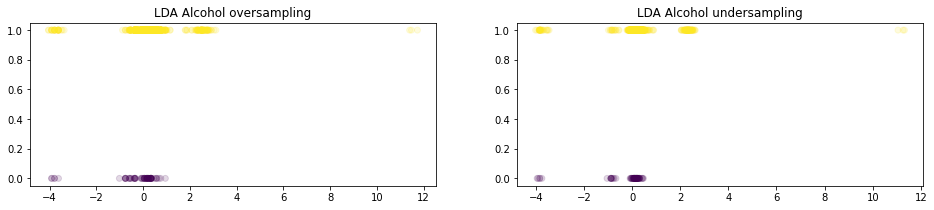

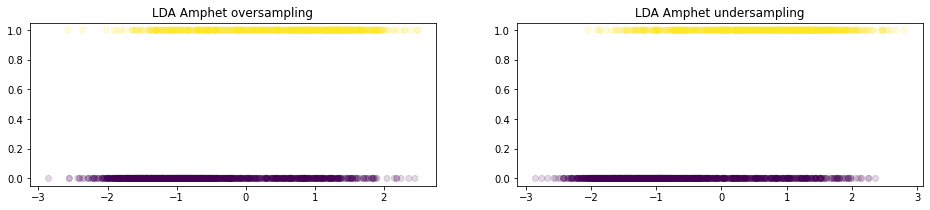

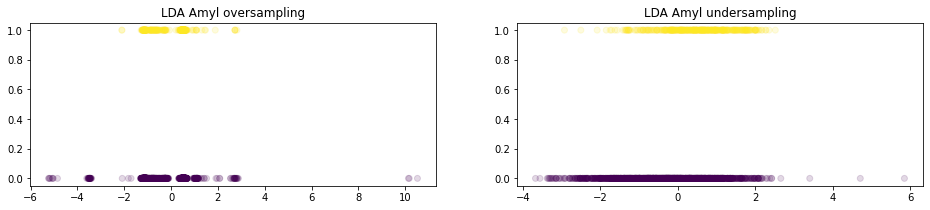

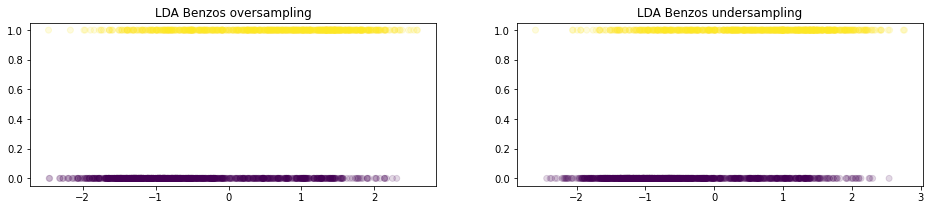

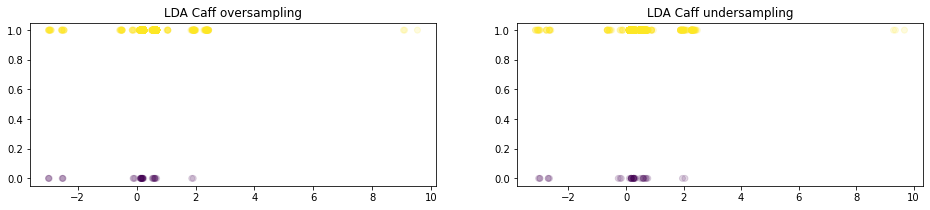

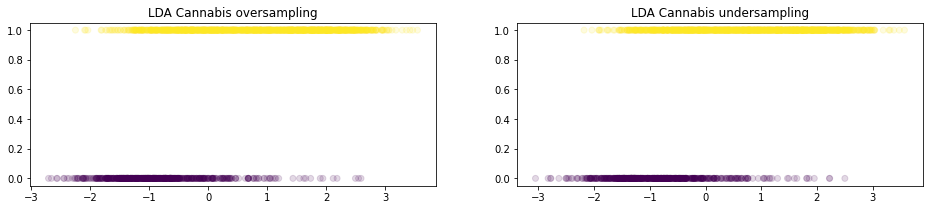

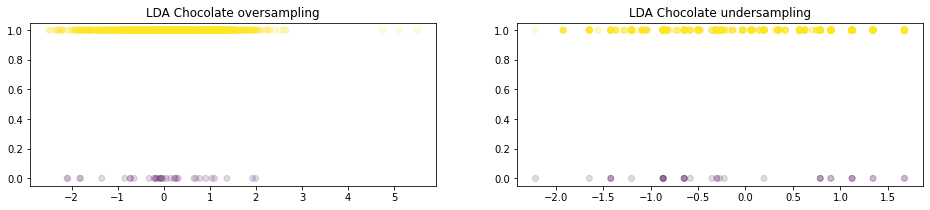

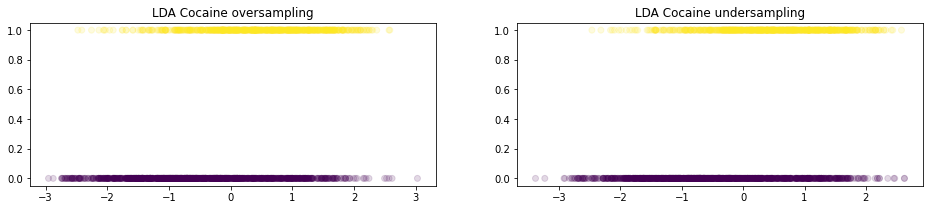

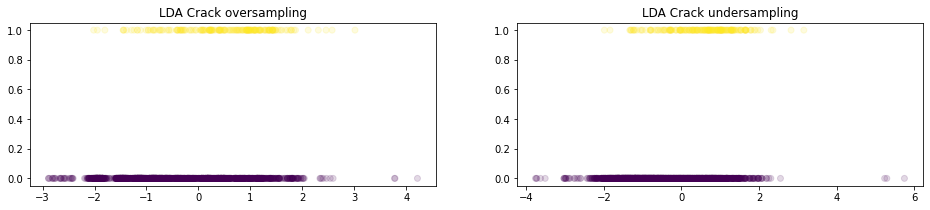

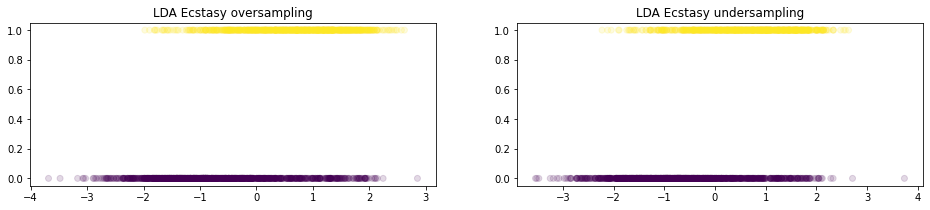

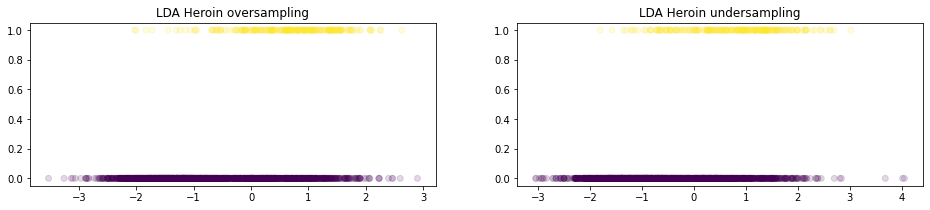

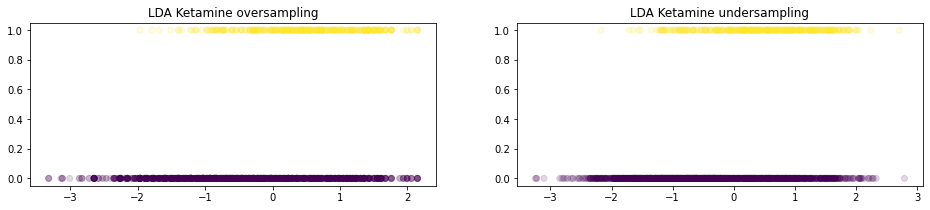

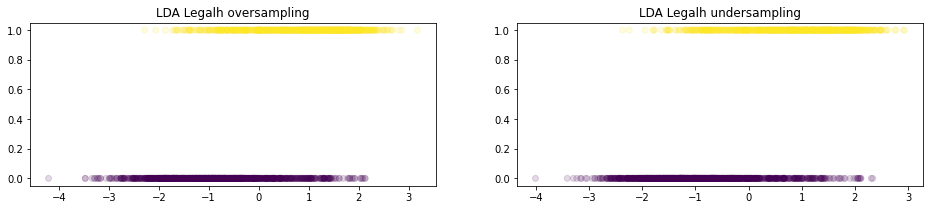

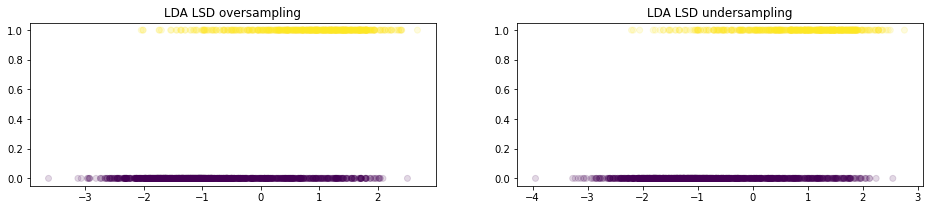

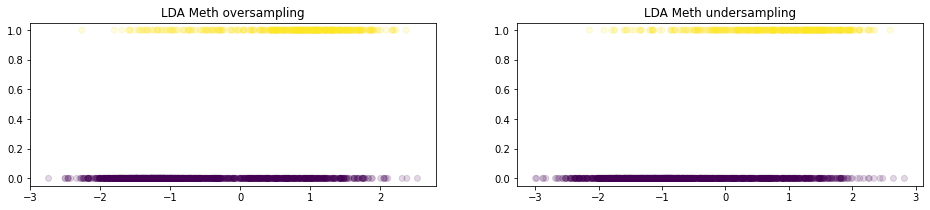

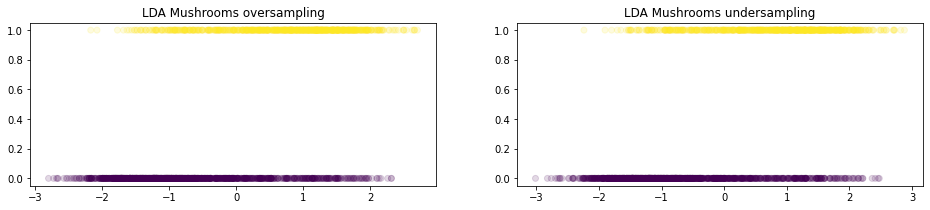

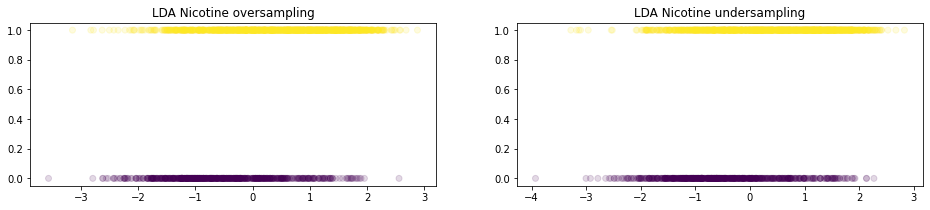

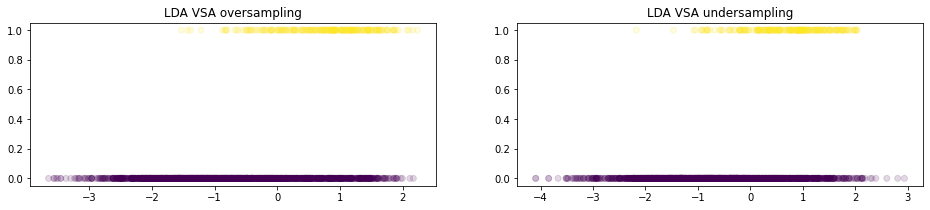

In [25]:
Zlda_over={}
Zlda_under={}
for drug in tipi_droghe:
    Zlda_over[drug] = lda_over[drug].transform(X_drugs_comb[keytop_over[drug]])
    Zlda_under[drug] = lda_under[drug].transform(X_drugs_comb[keytop_under[drug]])

    fig, axs = plt.subplots(1, 2, figsize=(16, 3))
    
    axs[0].scatter(Zlda_over[drug][:, 0],y[drug], c=y[drug], alpha=0.15)
    axs[0].set_title(f'LDA {drug} oversampling')
    axs[1].scatter(Zlda_under[drug][:, 0],y[drug], c=y[drug], alpha=0.15)
    axs[1].set_title(f'LDA {drug} undersampling')

# Multi-Layer Perceptron

I *Multi-Layer Perceptron* (MLP) sono un'esempio
di _Rete Neurale_ o _Neural Network_ (NN). Sono un particolare tipo di _feedforward_ NN (cioè senza ricorsività/cicli nella sua struttura) caratterizzato da una sequenza di _strati completamente connessi_ (_fully-connected layers_, *FC Layers*).

Sia $L$ un FC layer di $m$ unità con funzione di attivazione $\sigma:\mathbb{R}\rightarrow\mathbb{R}$ e sia $L$ (completamente) connesso con un altro livello di $n$ unità. Il layer $L$ è quindi caratterizzato dalla funzione $\mathcal{L}:\mathbb{R}^n\rightarrow\mathbb{R}^m$ tale che
$$ \mathcal{L}(x) := \sigma\left(W\boldsymbol{x} + \boldsymbol{b}\right)\,,\quad \forall \ \boldsymbol{x}\in\mathbb{R}^n\,$$,
dove:
- $W\in\mathbb{R}^{m\times n}$ è la matrice dei pesi del livello $L$;
- $\boldsymbol{b}\in\mathbb{R}^m$ è il vettore dei bias
- $\boldsymbol{\sigma}:\mathbb{R}^m\rightarrow\mathbb{R}^m$ è una funzione vettoriale che applica elemento-per-elemento la funzione $\sigma$.

Un _Input Layer_ di $n$ unità è un layer che "_legge_" vettori di $\mathbb{R}^n$ e li "_invia_" ai layer successivi con lui connessi.

Nelle MLP un input layer è poi seguito da una serie di hidden layers che precedono l'output layer. 
L'MLP in questione è quindi rappresentato da una funzione $\hat{\boldsymbol{F}}:\mathbb{R}^n\rightarrow \mathbb{R}^m$ tale che

$$
\hat{\boldsymbol{F}}(\boldsymbol{x}) : \mathbb{R}^n \xrightarrow[]{\mathcal{L}^{(1)}} \mathbb{R}^{n_1} \xrightarrow[]{\mathcal{L}^{(2)}} \cdots \xrightarrow[]{\mathcal{L}^{(H)}} \mathbb{R}^{n_H}\xrightarrow[]{\mathcal{L}^{(H+1)}}\mathbb{R}^m
$$

Quindi una dopo l'altra vengono applicate tutte le diverse funzioni di attivazione che caratterizzano il layer.


L'obbiettivo è, data una funzione target $\boldsymbol{F}$, per addestrare un MLP con funzione parametrica $\hat{\boldsymbol{F}}_\boldsymbol{w}$ ad apprendere $\boldsymbol{F}$, risolvere il problema

$$
\min_{\boldsymbol{w}} \left\lbrace \mathrm{Loss}(\boldsymbol{w}):= \sum_{\boldsymbol{x}\in\mathbb{R}^n}|\boldsymbol{F}(\boldsymbol{x}) - \hat{\boldsymbol{F}}_{\boldsymbol{w}}(\boldsymbol{x})|\right\rbrace\,
$$
ovvero vorremmo trovare $\boldsymbol{w}^*$ tale che $\mathrm{Loss}(\boldsymbol{w}^*)=0$.

Nella realtà però abbiamo solo le valutazioni $y=F$($x$), quindi il problema va ri-adattato alla pratica, cioè ai soli dati disponibili contenuti nel training set. Il metodo più utilizzato sfrutta dei batch dei dati, ovvero una partizione $\mathcal{B}$ del training set per minimizzare 
$$
\mathrm{Loss}_{\,\mathcal{B}}(\boldsymbol{w}):= \sum_{(\boldsymbol{x}, \boldsymbol{y})\in\mathcal{B}}|\boldsymbol{y} - \hat{\boldsymbol{F}}_{w}(\boldsymbol{x})|$$
Si può riassumere l'addestramento nei seguenti passi: 
1. **Inizializzazione Pesi:** genero dei pesi $\boldsymbol{w}$ e li assegno all'architettura del mio MLP (ottengo quindi $\hat{\boldsymbol{F}}_{\boldsymbol{w}}$);
2. **Finché** non viene raggiunto un criterio di arresto, ripeto:
    1. **Genero Casualmente** una $K$-partizione in minibatch _distinti_ $\mathcal{B}_1,\ldots , \mathcal{B}_K$ di $\mathcal{T}$;
    2. **Per ogni** $k=1,\ldots , K$:
        1. **Aggiornamento Pesi:** $\boldsymbol{w}\gets \boldsymbol{w} - \alpha \nabla \mathrm{Loss}_{\,\mathcal{B}_k}(\boldsymbol{w})$;
    
Ogni ripetizione dei passi del punto 2. è detto _EPOCA DI ADDESTRAMENTO_. Il parametro $\alpha$, è il _tasso di apprendimento_ (_learning rate_).

I criteri di arresto principali per l'addestramento di una NN sono quindi i seguenti:
1. Fissare un numero massimo $e_{\max}\in\mathbb{N}$ di epoche da eseguire;
2. Fissare una numero massimo $p\in\mathbb{N}$ di epoche di tolleranza rispetto al quale posso accettare che la loss su $\mathcal{V}$ cresca invece di diminuire. Oltre a ridurre i tempi di addestramento, questo criterio serve ad impedire di addestrare eccessivamente il modello e così rischiare di cadere in **overfitting**.

Utilizzo il metodo di MLP, ma primo applico una Grid-Search per ottenere i migliori iperparametri. A causa di costi computazionali molto alti studio l'andamento con due diversi tipi di batch e due diversi numeri di iterazioni di pazienza.

In [14]:
hidden_layer_sizes = 100
max_epochs_list = 1000
activation = 'relu'
batch_sz_list=[8,32]
patience_list=[10,40]
solver='adam'
random_state=123
validation_fraction=0.2
hparameters = {'batch_size':batch_sz_list, 'n_iter_no_change':patience_list}
mlp=MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, validation_fraction=validation_fraction,
                            activation=activation, solver=solver, max_iter=max_epochs_list,
                            random_state=random_state,early_stopping=True)
mlp_gs={}
for drug in tipi_droghe:
    mlp_gs[drug] = GridSearchCV(estimator=mlp,
                                param_grid=hparameters, 
                                scoring='f1_weighted',
                                return_train_score=True)
    mlp_gs[drug].fit(X_drugs,y[drug])

In [16]:
%store mlp_gs
%store mlp
%store -r mlp
%store -r mlp_gs

Stored 'mlp_gs' (dict)
Stored 'mlp' (MLPClassifier)


#### Over Sampling

La MLP viene addestrata sui dati bilanciati dell'oversampling e successivamente testata sui dati tenuti come porzione di testing.

In [20]:
mlp_gs_over={}
for drug in tipi_droghe:
    X_train, X_test, y_train, y_test = train_test_split(X_drugs, y[drug], train_size = 0.5, random_state=1, shuffle=True, stratify=y[drug])
    X_over_train, y_over_train = ros.fit_resample(X_train, y_train)
    
    mlp_gs_over[drug]=mlp_gs[drug].best_estimator_.fit(X_over_train,y_over_train)

#### Under Sampling

La MLP viene addestrata sui dati bilanciati dell'undersampling e successivamente testata sui dati tenuti come porzione di testing.

In [ ]:
mlp_gs_under={}
for drug in tipi_droghe:   
    print(f'Inizio {drug}')
    mlp_gs_under[drug] = GridSearchCV(estimator=mlp,
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True)
    X_train, X_test, y_train, y_test = train_test_split(X_drugs, y[drug], train_size = 0.5, random_state=1, shuffle=True, stratify=y[drug])

    X_under_train, y_under_train = rus.fit_resample(X_train, y_train)
    mlp_gs_under[drug]=mlp_gs[drug].best_estimator_.fit(X_under_train,y_under_train)

### Score MLP

Per ogni MLP stampo un dataframe con lo score, la precision, la recall e F1-score.

In [22]:
df_perf_mlp={}
for drug in tipi_droghe:   
    X_train, X_test, y_train, y_test = train_test_split(X_drugs, y[drug], train_size = 0.5, random_state=1, shuffle=True, stratify=y[drug])
    
    y_pred_over=mlp_gs_over[drug].predict(X_test)
    accover=mlp_gs_over[drug].score(X_test, y_test)
    preco = precision_score(y_test, y_pred_over, average='weighted')
    reco = recall_score(y_test, y_pred_over, average='weighted')
    f1o = f1_score(y_test, y_pred_over, average='weighted')
       

    y_pred_under=mlp_gs_under[drug].predict(X_test)    
    
    accunder=mlp_gs_under[drug].score(X_test, y_test)
    precu = precision_score(y_test, y_pred_under, average='weighted')
    recu = recall_score(y_test, y_pred_under, average='weighted')
    f1u = f1_score(y_test, y_pred_under, average='weighted')
    

    df_perf_mlp[drug] = pd.DataFrame({'Accuracy': [accover, accunder], 
                        'Precision': [preco, precu], 
                        'Recall': [reco, recu],
                        'F1': [f1o, f1u] },
                        index=['Oversampling', 'Undersampling'])

    display(df_perf_mlp[drug].style.set_caption(f"{drug}")) 
    

,Accuracy,Precision,Recall,F1
Oversampling,0.587859,0.944459,0.587859,0.709722
Undersampling,0.587859,0.944459,0.587859,0.709722


,Accuracy,Precision,Recall,F1
Oversampling,0.687966,0.707740,0.687966,0.693303
Undersampling,0.687966,0.707740,0.687966,0.693303


,Accuracy,Precision,Recall,F1
Oversampling,0.631523,0.786128,0.631523,0.669482
Undersampling,0.631523,0.786128,0.631523,0.669482


,Accuracy,Precision,Recall,F1
Oversampling,0.691161,0.705099,0.691161,0.693863
Undersampling,0.691161,0.705099,0.691161,0.693863


,Accuracy,Precision,Recall,F1
Oversampling,0.505857,0.965691,0.505857,0.653702
Undersampling,0.505857,0.965691,0.505857,0.653702


,Accuracy,Precision,Recall,F1
Oversampling,0.779553,0.824322,0.779553,0.786011
Undersampling,0.779553,0.824322,0.779553,0.786011


,Accuracy,Precision,Recall,F1
Oversampling,0.664537,0.961967,0.664537,0.783439
Undersampling,0.664537,0.961967,0.664537,0.783439


,Accuracy,Precision,Recall,F1
Oversampling,0.671991,0.705436,0.671991,0.678230
Undersampling,0.671991,0.705436,0.671991,0.678230


,Accuracy,Precision,Recall,F1
Oversampling,0.539936,0.873459,0.539936,0.626138
Undersampling,0.539936,0.873459,0.539936,0.626138


,Accuracy,Precision,Recall,F1
Oversampling,0.712460,0.728167,0.712460,0.715430
Undersampling,0.712460,0.728167,0.712460,0.715430


,Accuracy,Precision,Recall,F1
Oversampling,0.607029,0.878479,0.607029,0.678514
Undersampling,0.607029,0.878479,0.607029,0.678514


,Accuracy,Precision,Recall,F1
Oversampling,0.627263,0.800693,0.627263,0.669119
Undersampling,0.627263,0.800693,0.627263,0.669119


,Accuracy,Precision,Recall,F1
Oversampling,0.793397,0.799414,0.793397,0.794817
Undersampling,0.793397,0.799414,0.793397,0.794817


,Accuracy,Precision,Recall,F1
Oversampling,0.757188,0.800632,0.757188,0.766788
Undersampling,0.757188,0.800632,0.757188,0.766788


,Accuracy,Precision,Recall,F1
Oversampling,0.628328,0.795759,0.628328,0.659457
Undersampling,0.628328,0.795759,0.628328,0.659457


,Accuracy,Precision,Recall,F1
Oversampling,0.741214,0.765188,0.741214,0.745687
Undersampling,0.741214,0.765188,0.741214,0.745687


,Accuracy,Precision,Recall,F1
Oversampling,0.647497,0.706596,0.647497,0.657810
Undersampling,0.647497,0.706596,0.647497,0.657810


,Accuracy,Precision,Recall,F1
Oversampling,0.636848,0.892625,0.636848,0.699546
Undersampling,0.636848,0.892625,0.636848,0.699546


In [23]:
%store df_perf_mlp
%store mlp_gs_over
%store mlp_gs_under

Stored 'df_perf_mlp' (dict)
Stored 'mlp_gs_over' (dict)
Stored 'mlp_gs_under' (dict)


In [21]:
%store -r df_perf_mlp
%store -r mlp_gs_over
%store -r mlp_gs_under

Creo degli istogrammi per analizzare con quale percentuale di accuratenzza vengono predette le classi per ogni istanza e ogni tipo di sostanza.

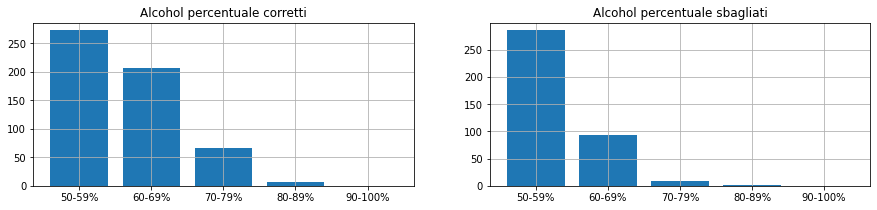

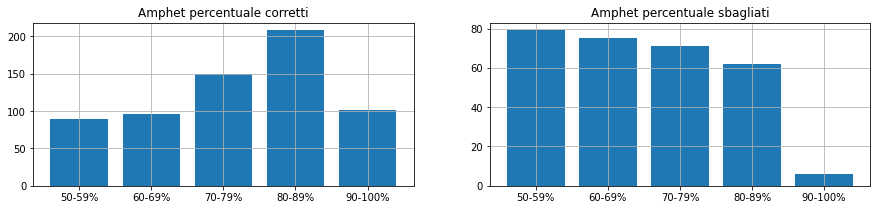

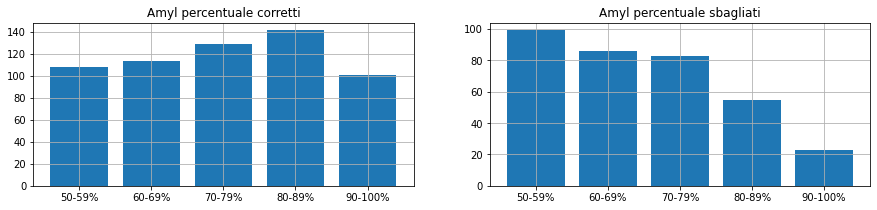

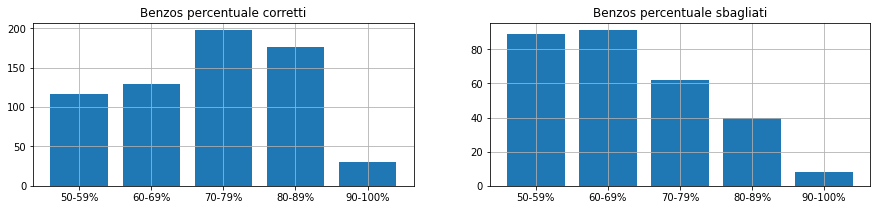

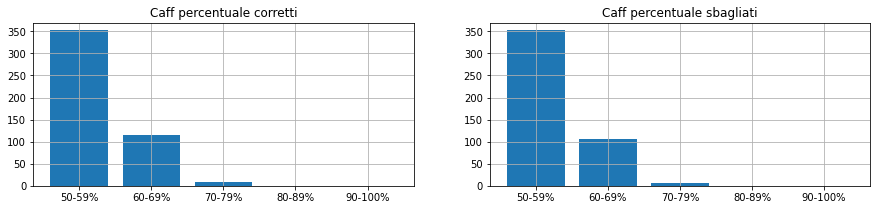

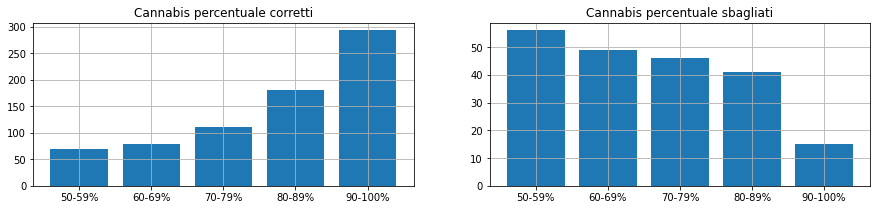

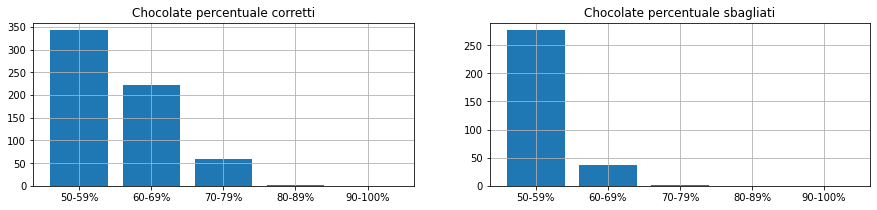

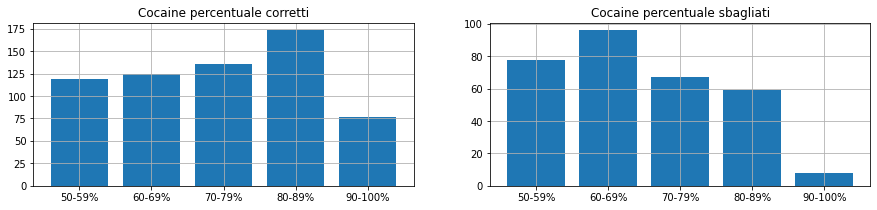

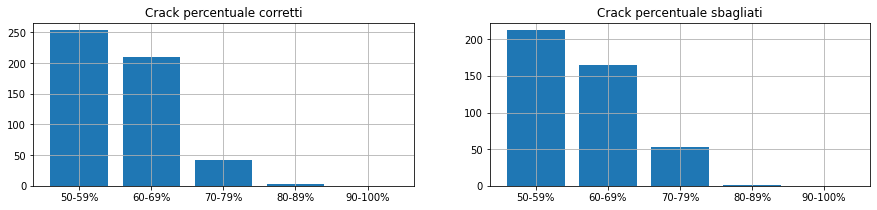

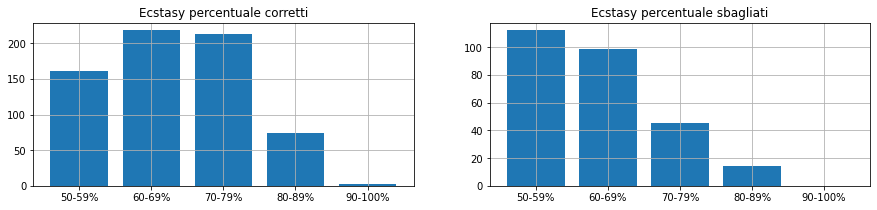

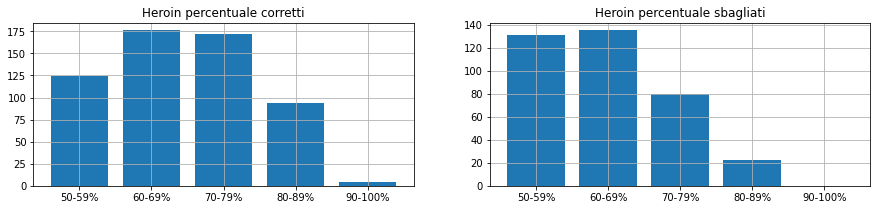

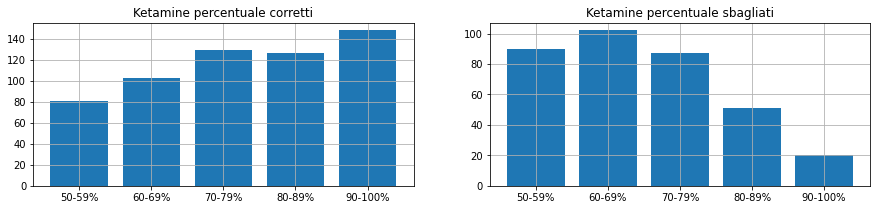

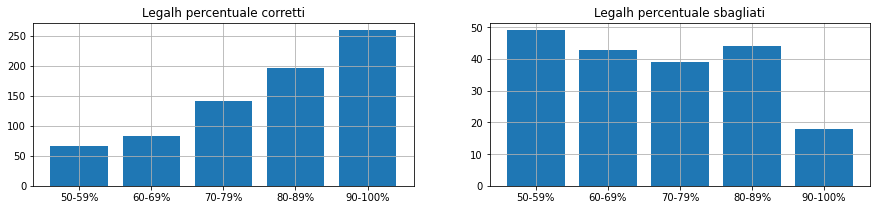

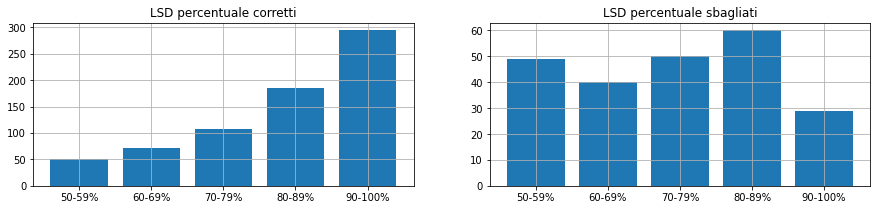

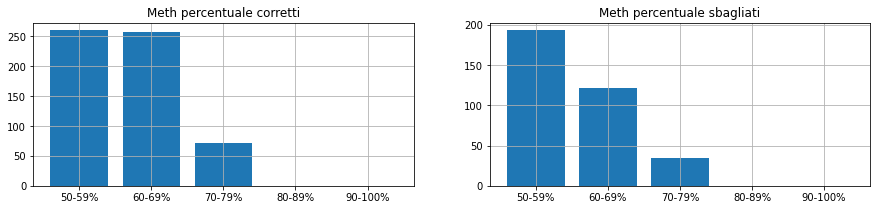

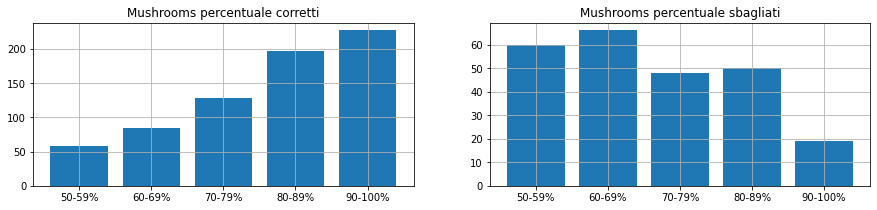

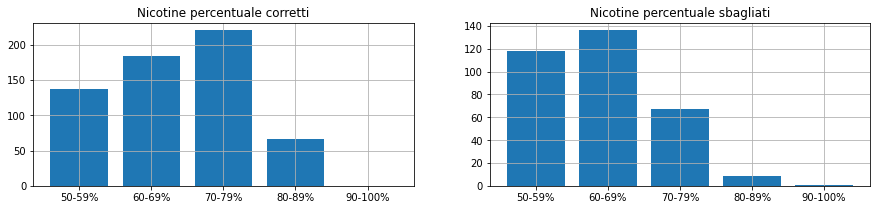

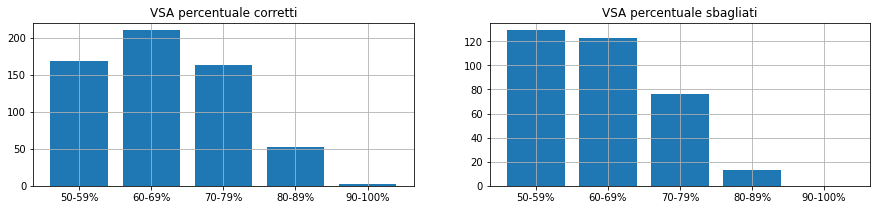

In [58]:
y_pred={}
y_pred_proba={}
y_test={}
for drug in tipi_droghe:
    X_train, X_test, y_train, y_test[drug] = train_test_split(X_drugs, y[drug], train_size = 0.5, random_state=1, shuffle=True, stratify=y[drug])
    y_pred[drug] = mlp_gs_over[drug].predict(X_test)
    y_pred_proba[drug] = mlp_gs_over[drug].predict_proba(X_test)

    corretti=[0,0,0,0,0]
    sbagliati=[0,0,0,0,0]
    
    for i in range(1,len(y_test[drug])):
        if y_test[drug][i]==y_pred[drug][i]:
            corretti[int(np.floor(y_pred_proba[drug][i,y_pred[drug][i]]*10))-5]=corretti[int(np.floor(y_pred_proba[drug][i,y_pred[drug][i]]*10))-5]+1
        else:
            sbagliati[int(np.floor(y_pred_proba[drug][i,y_pred[drug][i]]*10))-5]=sbagliati[int(np.floor(y_pred_proba[drug][i,y_pred[drug][i]]*10))-5]+1

    fig, axs = plt.subplots(1, 2, figsize=(15, 3))
    axs[0].bar([0,1,2,3,4], [corretti[0],corretti[1],corretti[2],corretti[3],corretti[4]])
    axs[0].set_xticks([0,1,2,3,4])
    axs[0].set_xticklabels(['50-59%','60-69%','70-79%','80-89%','90-100%'],)
    axs[0].set_title(f'{drug} percentuale corretti')
    axs[0].grid()
    axs[1].bar([0,1,2,3,4], [sbagliati[0],sbagliati[1],sbagliati[2],sbagliati[3],sbagliati[4]])
    axs[1].set_xticks([0,1,2,3,4])
    axs[1].set_xticklabels(['50-59%','60-69%','70-79%','80-89%','90-100%'],)
    axs[1].set_title(f'{drug} percentuale sbagliati')
    axs[1].grid()

# Non Linear (Kernel) Support Vector Machine

Quando i dati non sono linearmente separabili le SVM lineari falliscono indipendentemente dal parametro C scelto.  
L'idea delle SVM non lineari è quello di proiettare i dati in uno spazio di dimensione superiore, detto *spazio delle features*, dove la separazione delle classi diventa lineare. Ovvero dato il training set, si sceglie una mappa, tipicamente non lineare $\phi :\mathbb{R}^n\rightarrow \mathbb{R}^m\,$ con $m>n$ e risolvo il problema con una SVM ripsetto al nuovo training set $$\mathcal{T}^\phi = \{ \left(\boldsymbol{\varphi}_1,y_1\right),\ldots , \left(\boldsymbol{\varphi}_T),y_T\right)\}\in\mathbb{R}^m\times \{\pm 1\}\,, \quad \text{con }\boldsymbol{\varphi}_i = \phi(\boldsymbol{x}_i),\, \forall \ i=1,\ldots ,T\,, $$

Ci sono però due problemi a cui si va incontro:
1. Aumentare la dimensione del problema comporta un aggravio dei costi computazionali;
2. Scegliere la giusta mappa $\phi$ non è sempre facile per avere dei calcoli leggeri.

La soluzione è data dal *kernel trick*. Sia $\mathcal{X}\subseteq\mathbb{R}^n$ il dominio dei vettori $\boldsymbol{x}$ del mio problema di classificazione. In poche parole, un _Kernel_ $k$ è una funzione 

$$k:\mathcal{X}\times \mathcal{X}\rightarrow\mathbb{R}$$

per cui esiste un'unica mappa 

$$\phi:\mathcal{X}\rightarrow\mathcal{H}\subseteq\mathbb{R}^m\,,$$

con $m>n$ ed $\mathcal{H}$ spazio di _Hilbert_, per cui il prodotto scalare in $\mathcal{H}$ di $\boldsymbol{\varphi}_i=\phi(\boldsymbol{x}_i)$ e $\boldsymbol{\varphi}_j=\phi(\boldsymbol{x}_j)$, per ogni $\boldsymbol{x}_i,\boldsymbol{x}_j\in\mathcal{X}$, è definito da $k$; in altre parole:

$$\langle\boldsymbol{\varphi}_i,\boldsymbol{\varphi}_j\rangle_{\mathcal{H}} = k(\boldsymbol{x}_i,\boldsymbol{x}_j)$$
Il kernel trick risolve i due problemi sopra citati poichè i conti sono sempre svolti in $\mathbb{R}^n$ e non è neccesario conoscere esplicitamente $\phi$ perchè basta scegliere il kernel.

I kernel più utilizzati sono:
- lineare     $
\langle\boldsymbol{\varphi}_i, \boldsymbol{\varphi}_j\rangle_{\mathcal{H}} = \langle \boldsymbol{x}_i, \boldsymbol{x}_j\rangle_{\mathcal{X}}\,$;
- polinomiale     $
\langle \boldsymbol{\varphi}_i, \boldsymbol{\varphi}_j\rangle_{\mathcal{H}} = \left(\gamma \, \langle \boldsymbol{x}_i, \boldsymbol{x}_j\rangle_{\mathcal{X}} + c_0 \right)^d\,$;
- radial basis function (RBF)     $\langle \boldsymbol{\varphi}_i, \boldsymbol{\varphi}_j\rangle_{\mathcal{H}} = e^{-\gamma \, \langle \boldsymbol{x}_i, \boldsymbol{x}_j\rangle_{\mathcal{X}}^2}\,$;
- sigmoidale      $\langle \boldsymbol{\varphi}_i, \boldsymbol{\varphi}_j\rangle_{\mathcal{H}} = \mathrm{tanh}\left(\gamma \, \langle \boldsymbol{x}_i, \boldsymbol{x}_j\rangle_{\mathcal{X}} + c_0 \right)\,$;

Anche per la SVM applico una Grid-Search per trovare i migliori iper-paramentri

In [26]:
C_list = [2**i for i in range(-2,3)]
gamma_list = ['auto', 'scale']
ker_list = ['rbf','sigmoid','poly','linear']

hparameters = {'kernel':ker_list, 'C':C_list, 'gamma':gamma_list} #dizionario
svm = SVC(class_weight='balanced')

svm_gs={}
for drug in tipi_droghe:   
    svm_gs[drug] = GridSearchCV(estimator=svm, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True)

    svm_gs[drug].fit(X_drugs,y[drug])

In [27]:
%store svm_gs
%store -r svm_gs

Stored 'svm_gs' (dict)


In [42]:
for drug in tipi_droghe:
    print(drug)
    display(pd.DataFrame(svm_gs[drug].cv_results_).loc[0,'params'])

Alcohol


{'C': 0.25, 'gamma': 'auto', 'kernel': 'rbf'}

Amphet


{'C': 0.25, 'gamma': 'auto', 'kernel': 'rbf'}

Amyl


{'C': 0.25, 'gamma': 'auto', 'kernel': 'rbf'}

Benzos


{'C': 0.25, 'gamma': 'auto', 'kernel': 'rbf'}

Caff


{'C': 0.25, 'gamma': 'auto', 'kernel': 'rbf'}

Cannabis


{'C': 0.25, 'gamma': 'auto', 'kernel': 'rbf'}

Chocolate


{'C': 0.25, 'gamma': 'auto', 'kernel': 'rbf'}

Cocaine


{'C': 0.25, 'gamma': 'auto', 'kernel': 'rbf'}

Crack


{'C': 0.25, 'gamma': 'auto', 'kernel': 'rbf'}

Ecstasy


{'C': 0.25, 'gamma': 'auto', 'kernel': 'rbf'}

Heroin


{'C': 0.25, 'gamma': 'auto', 'kernel': 'rbf'}

Ketamine


{'C': 0.25, 'gamma': 'auto', 'kernel': 'rbf'}

Legalh


{'C': 0.25, 'gamma': 'auto', 'kernel': 'rbf'}

LSD


{'C': 0.25, 'gamma': 'auto', 'kernel': 'rbf'}

Meth


{'C': 0.25, 'gamma': 'auto', 'kernel': 'rbf'}

Mushrooms


{'C': 0.25, 'gamma': 'auto', 'kernel': 'rbf'}

Nicotine


{'C': 0.25, 'gamma': 'auto', 'kernel': 'rbf'}

VSA


{'C': 0.25, 'gamma': 'auto', 'kernel': 'rbf'}

## Score e matrice di confusione per la SVM

Per ogni SVM stampo un dataframe con lo score, la precision, la recall e F1-score. In aggiunta stampo anche la matrice di confusione.

In [57]:
df_perf_svm={}
for drug in tipi_droghe:   
    X_train, X_test, y_train, y_test = train_test_split(X_drugs, y[drug], train_size = 0.5, random_state=1, shuffle=True, stratify=y[drug])
    
    X_over_train, y_over_train = ros.fit_resample(X_train, y_train)
    svm_gs[drug].best_estimator_.fit(X_over_train, y_over_train)
    
    y_pred_over=svm_gs[drug].predict(X_test)
    accover=svm_gs[drug].score(X_test, y_test)
    preco = precision_score(y_test, y_pred_over, average='weighted')
    reco = recall_score(y_test, y_pred_over, average='weighted')
    f1o = f1_score(y_test, y_pred_over, average='weighted')
    
    X_under_train, y_under_train = rus.fit_resample(X_train, y_train)
    svm_gs[drug].best_estimator_.fit(X_under_train,y_under_train)
    
    y_pred_under=svm_gs[drug].predict(X_test)
    accunder=svm_gs[drug].score(X_test, y_test)
    precu = precision_score(y_test, y_pred_under, average='weighted')
    recu = recall_score(y_test, y_pred_under, average='weighted')
    f1u = f1_score(y_test, y_pred_under, average='weighted')
    

    df_perf_svm[drug] = pd.DataFrame({'Accuracy': [accover, accunder], 
                        'Precision': [preco, precu], 
                        'Recall': [reco, recu],
                        'F1': [f1o, f1u]},
                      index=['Oversampling', 'Undersampling'])
    
    cmat_over = confusion_matrix(y_test, y_pred_over)
    cmat_under = confusion_matrix(y_test, y_pred_under)
    
    df_cmat_over = pd.DataFrame(cmat_over, columns=[f'Non {drug} over ',f'{drug} over'], index=['Non user','User'])
    df_cmat_under = pd.DataFrame(cmat_under, columns=[f'Non {drug} under',f'{drug} under'], index=['Non user','User'])

    display(df_perf_svm[drug].style.set_caption(f"{drug}"), pd.concat([df_cmat_under,df_cmat_over], axis=1).style.set_caption(f"Confusion matrix {drug}"))
    

,Accuracy,Precision,Recall,F1
Oversampling,0.924609,0.933890,0.915868,0.924609
Undersampling,0.676828,0.946538,0.548456,0.676828


,Non Alcohol under,Alcohol under,Non Alcohol over,Alcohol over
Non user,24,10,4,30
User,414,491,49,856


,Accuracy,Precision,Recall,F1
Oversampling,0.698678,0.708047,0.694356,0.698678
Undersampling,0.687891,0.712303,0.681576,0.687891


,Non Amphet under,Amphet under,Non Amphet over,Amphet over
Non user,398,204,430,172
User,95,242,115,222


,Accuracy,Precision,Recall,F1
Oversampling,0.731035,0.763154,0.711395,0.731035
Undersampling,0.632188,0.787318,0.591054,0.632188


,Non Amyl under,Amyl under,Non Amyl over,Amyl over
Non user,413,342,573,182
User,42,142,89,95


,Accuracy,Precision,Recall,F1
Oversampling,0.693609,0.693054,0.694356,0.693609
Undersampling,0.693609,0.693054,0.694356,0.693609


,Non Benzos under,Benzos under,Non Benzos over,Benzos over
Non user,420,138,420,138
User,149,232,149,232


,Accuracy,Precision,Recall,F1
Oversampling,0.956807,0.959421,0.954207,0.956807
Undersampling,0.698006,0.969018,0.558040,0.698006


,Non Caff under,Caff under,Non Caff over,Caff over
Non user,13,6,0,19
User,409,511,24,896


,Accuracy,Precision,Recall,F1
Oversampling,0.791696,0.816925,0.785942,0.791696
Undersampling,0.784921,0.820843,0.778488,0.784921


,Non Cannabis under,Cannabis under,Non Cannabis over,Cannabis over
Non user,271,39,262,48
User,169,460,153,476


,Accuracy,Precision,Recall,F1
Oversampling,0.969265,0.968370,0.970181,0.969265
Undersampling,0.687702,0.964906,0.542066,0.687702


,Non Chocolate under,Chocolate under,Non Chocolate over,Chocolate over
Non user,8,9,2,15
User,421,501,13,909


,Accuracy,Precision,Recall,F1
Oversampling,0.669859,0.703879,0.663472,0.669859
Undersampling,0.667710,0.704170,0.661342,0.667710


,Non Cocaine under,Cocaine under,Non Cocaine over,Cocaine over
Non user,368,230,372,226
User,88,253,90,251


,Accuracy,Precision,Recall,F1
Oversampling,0.828701,0.859384,0.806177,0.828701
Undersampling,0.669987,0.882585,0.589989,0.669987


,Non Crack under,Crack under,Non Crack over,Crack over
Non user,479,366,718,127
User,19,75,55,39


,Accuracy,Precision,Recall,F1
Oversampling,0.715526,0.732201,0.712460,0.715526
Undersampling,0.713399,0.733845,0.710330,0.713399


,Non Ecstasy under,Ecstasy under,Non Ecstasy over,Ecstasy over
Non user,378,188,385,181
User,84,289,89,284


,Accuracy,Precision,Recall,F1
Oversampling,0.806141,0.841973,0.780618,0.806141
Undersampling,0.722183,0.875894,0.659212,0.722183


,Non Heroin under,Heroin under,Non Heroin over,Heroin over
Non user,537,297,689,145
User,23,82,61,44


,Accuracy,Precision,Recall,F1
Oversampling,0.725057,0.759597,0.702875,0.725057
Undersampling,0.666151,0.780814,0.624068,0.666151


,Non Ketamine under,Ketamine under,Non Ketamine over,Ketamine over
Non user,469,297,579,187
User,56,117,92,81


,Accuracy,Precision,Recall,F1
Oversampling,0.794318,0.796282,0.793397,0.794318
Undersampling,0.792261,0.794476,0.791267,0.792261


,Non Legalh under,Legalh under,Non Legalh over,Legalh over
Non user,450,111,452,109
User,85,293,85,293


,Accuracy,Precision,Recall,F1
Oversampling,0.762983,0.800414,0.752929,0.762983
Undersampling,0.775805,0.807460,0.766773,0.775805


,Non LSD under,LSD under,Non LSD over,LSD over
Non user,496,167,483,180
User,52,224,52,224


,Accuracy,Precision,Recall,F1
Oversampling,0.749988,0.786653,0.732694,0.749988
Undersampling,0.713511,0.809581,0.686901,0.713511


,Non Meth under,Meth under,Non Meth over,Meth over
Non user,476,256,551,181
User,38,169,70,137


,Accuracy,Precision,Recall,F1
Oversampling,0.741863,0.753385,0.738019,0.741863
Undersampling,0.750606,0.765419,0.746539,0.750606


,Non Mushrooms under,Mushrooms under,Non Mushrooms over,Mushrooms over
Non user,436,159,438,157
User,79,265,89,255


,Accuracy,Precision,Recall,F1
Oversampling,0.704244,0.715287,0.698616,0.704244
Undersampling,0.702502,0.708531,0.698616,0.702502


,Non Nicotine under,Nicotine under,Non Nicotine over,Nicotine over
Non user,188,123,199,112
User,160,468,171,457


,Accuracy,Precision,Recall,F1
Oversampling,0.833756,0.854418,0.818956,0.833756
Undersampling,0.753895,0.876843,0.702875,0.753895


,Non VSA under,VSA under,Non VSA over,VSA over
Non user,570,256,713,113
User,23,90,57,56


In [ ]:
%store df_perf_svm

In [56]:
%store -r df_perf_svm

### Conclusioni

Dopo aver analizzato tre metodi di data classification scelgo come metodo più valido quello con F1-score maggiore.

In [57]:
for drug in tipi_droghe:  
    s1=df_perf_lda[drug].loc[:,'F1']
    s1=s1.rename('F1 LDA')
    s2=df_perf_mlp[drug].loc[:,'F1']
    s2=s2.rename('F1 MLP')
    s3=df_perf_svm[drug].loc[:,'F1']
    s3=s3.rename('F1 SVM RBF')    
    final=pd.concat([s1,s2,s3], axis=1)
    display(final.style.set_caption(f"{drug}"))

,F1 LDA,F1 MLP,F1 SVM RBF
Oversampling,0.903924,0.709722,0.924609
Undersampling,0.912902,0.709722,0.676828


,F1 LDA,F1 MLP,F1 SVM RBF
Oversampling,0.710732,0.693303,0.698678
Undersampling,0.713712,0.693303,0.687891


,F1 LDA,F1 MLP,F1 SVM RBF
Oversampling,0.690268,0.669482,0.731035
Undersampling,0.706155,0.669482,0.632188


,F1 LDA,F1 MLP,F1 SVM RBF
Oversampling,0.716402,0.693863,0.693609
Undersampling,0.714518,0.693863,0.693609


,F1 LDA,F1 MLP,F1 SVM RBF
Oversampling,0.957895,0.653702,0.956807
Undersampling,0.957895,0.653702,0.698006


,F1 LDA,F1 MLP,F1 SVM RBF
Oversampling,0.788160,0.786011,0.791696
Undersampling,0.792300,0.786011,0.784921


,F1 LDA,F1 MLP,F1 SVM RBF
Oversampling,0.818377,0.783439,0.969265
Undersampling,0.823934,0.783439,0.687702


,F1 LDA,F1 MLP,F1 SVM RBF
Oversampling,0.685372,0.678230,0.669859
Undersampling,0.689481,0.678230,0.667710


,F1 LDA,F1 MLP,F1 SVM RBF
Oversampling,0.746490,0.626138,0.828701
Undersampling,0.739093,0.626138,0.669987


,F1 LDA,F1 MLP,F1 SVM RBF
Oversampling,0.744808,0.715430,0.715526
Undersampling,0.749870,0.715430,0.713399


,F1 LDA,F1 MLP,F1 SVM RBF
Oversampling,0.761877,0.678514,0.806141
Undersampling,0.741232,0.678514,0.722183


,F1 LDA,F1 MLP,F1 SVM RBF
Oversampling,0.704912,0.669119,0.725057
Undersampling,0.707584,0.669119,0.666151


,F1 LDA,F1 MLP,F1 SVM RBF
Oversampling,0.807213,0.794817,0.794318
Undersampling,0.804169,0.794817,0.792261


,F1 LDA,F1 MLP,F1 SVM RBF
Oversampling,0.781790,0.766788,0.762983
Undersampling,0.780554,0.766788,0.775805


,F1 LDA,F1 MLP,F1 SVM RBF
Oversampling,0.768472,0.659457,0.749988
Undersampling,0.775293,0.659457,0.713511


,F1 LDA,F1 MLP,F1 SVM RBF
Oversampling,0.769084,0.745687,0.741863
Undersampling,0.765067,0.745687,0.750606


,F1 LDA,F1 MLP,F1 SVM RBF
Oversampling,0.687401,0.657810,0.704244
Undersampling,0.680454,0.657810,0.702502


,F1 LDA,F1 MLP,F1 SVM RBF
Oversampling,0.776364,0.699546,0.833756
Undersampling,0.769626,0.699546,0.753895
